In [1]:
# Adding all needed imports

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras import layers
from keras.models import Model
#print(tf.keras.__version__)
#print(tf.__version__)
import numpy as np
from keras.utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


Load the numpy files into memory to act as the dataset
Splits the validation data into 2 so that half can be used as the test data, making the data split 70/15/15 train/validation/test

In [2]:
dataTrain = np.load("dataProcessing/finished/stTrain.npy", allow_pickle=True)
targetTrain = np.load("dataProcessing/finished/stTrainTarget.npy", allow_pickle=True)


dataVal = np.load("dataProcessing/finished/stVal.npy", allow_pickle=True)
targetVal = np.load("dataProcessing/finished/stValTarget.npy", allow_pickle=True)


print(len(dataTrain[0]))
print(len(targetTrain[0]))
print(len(dataTrain))
print(len(targetTrain))


dataTest = dataVal[0:15]
targetTest = targetVal[0:15]


dataVal = dataVal[15:]
targetVal = targetVal[15:]


151
151
70
70


Final data processing step - the neural network uses a 3-d array as the input, in this case 30 rows of data. Each simulation is sampled at a step rate of 5 cycles

In [3]:
numRows = 30
step = 5



def finalSplit(data, targets, numRows, step):
    div = int(numRows/2)
    splits = []
    splitsTarget = []
    for each in range(len(data)):
        run = data[each]
        target = targets[each]
        for i in range(div, len(target) - div, step):
            split = []
            RUL = 0
            for j in range(-div,div):
                index = i + j
                element = run[index].copy()
                RUL = target[index]
                split.append(element)
            splits.append(split)
            splitsTarget.append(RUL)
            
    return splits, splitsTarget

In [4]:
dataSplitTrain, targetSplitTrain = finalSplit(dataTrain, targetTrain, numRows, step)
dataSplitVal, targetSplitVal = finalSplit(dataVal, targetVal, numRows, step)
dataSplitTest, targetSplitTest = finalSplit(dataTest, targetTest, numRows, step)

print(len(dataSplitTrain))
print(len(dataSplitVal))

1735
375


In [5]:
dataSplitTrain = np.array(dataSplitTrain)
targetSplitTrain = np.array(targetSplitTrain)
dataSplitVal = np.array(dataSplitVal)
targetSplitVal = np.array(targetSplitVal)
dataSplitTest = np.array(dataSplitTest)
targetSplitTest = np.array(targetSplitTest)


width = len(dataSplitTrain[0][0])
print(width)

11


Model creation, compiling and calling the fit function. Sequential isn't used to make it possible to experiment with parallel neural nets

In [6]:
visible = layers.Input(shape=(numRows, width,))

cnn = layers.Conv1D(width, 3, activation='relu')(visible)
rnn1 = layers.GRU(150, dropout=0.2)(cnn)
#rnn2 = layers.GRU(150, dropout=0.2)(rnn1)

#rnnX = layers.LSTM(300, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(visible)
#rnnY = layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2)(rnnX)

dense = layers.Dense(150, activation='relu')(rnn1)
drop = layers.Dropout(0.2)(dense)
out = layers.Dense(1, activation='linear')(drop)

model = Model(inputs=visible, outputs=out)


print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 11)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 11)            374       
_________________________________________________________________
gru_1 (GRU)                  (None, 150)               72900     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 96,075
Trainable params: 96,075
Non-trainable params: 0
_______________________________________________________

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005),
              loss='mse', 
              metrics=['mae'])


In [8]:
history = model.fit(dataSplitTrain, targetSplitTrain, epochs=50, verbose=1, validation_data=(dataSplitVal,targetSplitVal))

Train on 1735 samples, validate on 375 samples
Epoch 1/50
1735/1735 [==============================] - 3s 2ms/step - loss: 2615.9193 - mae: 41.7303 - val_loss: 1385.7630 - val_mae: 31.8516
Epoch 2/50
1735/1735 [==============================] - 2s 1ms/step - loss: 886.6234 - mae: 24.2985 - val_loss: 424.7732 - val_mae: 16.3393
Epoch 3/50
1735/1735 [==============================] - 2s 1ms/step - loss: 456.4583 - mae: 17.1252 - val_loss: 355.1298 - val_mae: 15.2424
Epoch 4/50
1735/1735 [==============================] - 2s 1ms/step - loss: 421.8364 - mae: 16.2962 - val_loss: 337.5467 - val_mae: 14.4826
Epoch 5/50
1735/1735 [==============================] - 2s 1ms/step - loss: 400.8542 - mae: 15.7941 - val_loss: 470.0044 - val_mae: 17.8123
Epoch 6/50
1735/1735 [==============================] - 2s 1ms/step - loss: 395.1464 - mae: 15.7063 - val_loss: 413.8382 - val_mae: 16.5460
Epoch 7/50
1735/1735 [==============================] - 2s 1ms/step - loss: 371.8251 - mae: 15.0656 - val_loss:

Model is then evaluated with the remaining test data

In [9]:
model.evaluate(dataSplitTest, targetSplitTest)

372/372 [==============================] - 0s 365us/step


[230.9103777485509, 12.70921516418457]

Save the model to a json file and save the weights so it can be deployed elsewhere

In [10]:
#Save model
model_json = model.to_json()
with open("savedStates/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("savedStates/model.h5")
print("Saved model to disk")


Saved model to disk


Plot the graph of the model training over time

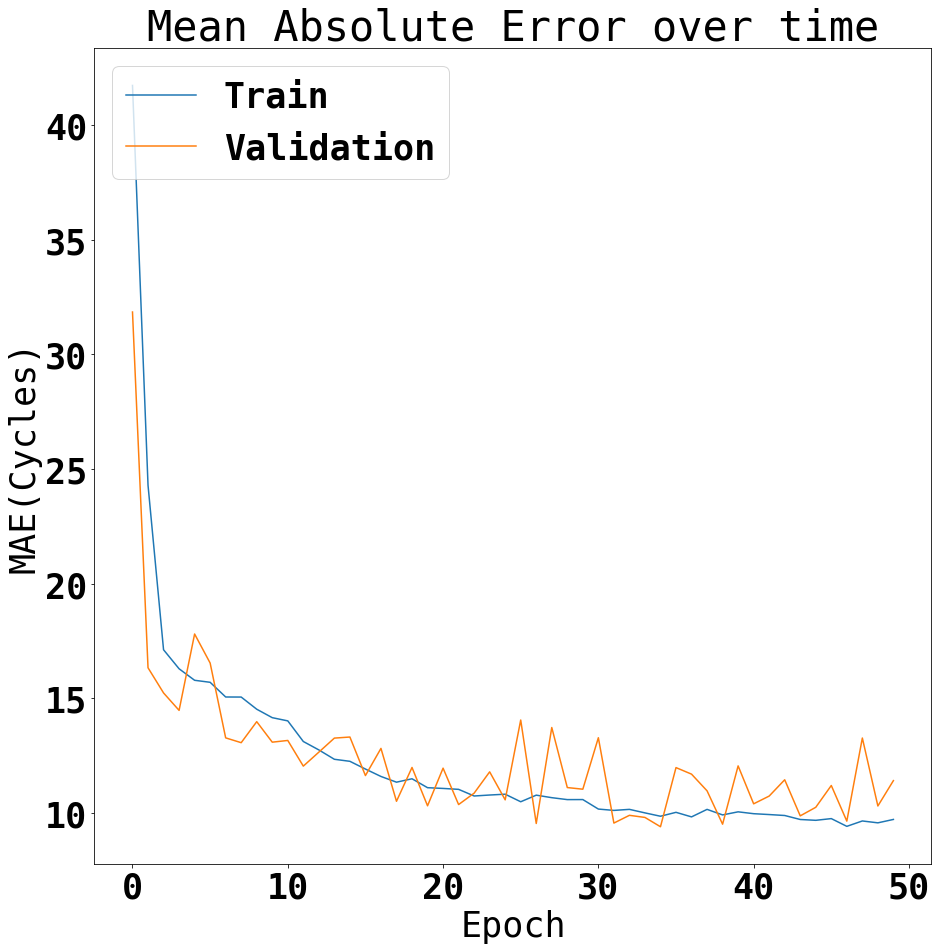

In [12]:
import matplotlib
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error over time')
plt.ylabel('MAE(Cycles)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 35}

matplotlib.rc('font', **font)



plt.savefig('FinalModel2.png',  bbox_inches='tight')